# Library and dataset import section: 

In [1]:
!featurize dataset download 3b2d6527-7a46-4237-84b5-605c9f9165fa

100%|████████████████████████████████████████| 506M/506M [00:03<00:00, 139MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
from PIL import Image, ImageChops, ImageEnhance
from torchvision import transforms
import os
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import torch
import time
import torchvision.models as models

# Image pre-process section:

In [3]:
# Convert an image to ela image
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [4]:
# Resize image to fixed size
# Input type: <class 'PIL.Image.Image'>
# Output type: <class 'PIL.Image.Image'>
def prepare_image(image_path, image_size):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(convert_to_ela_image(image_path, 85).resize(image_size))

# Real image

In [5]:
# real images
X = [] # ELA converted images
Y = [] # label: 0 for fake, 1 for real

image_size = (224, 224) 
path = 'data/CASIA2000/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(1)  

print(len(X), len(Y))

960 960


# Fake image

In [6]:
# fake images

image_size = (224, 224) 
path = 'data/CASIA2000/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        X.append(prepare_image(full_path, image_size))
        Y.append(0)

print(len(X), len(Y))

1920 1920


# Shuffle and split the data

In [7]:
# Shuffle the data
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [8]:
# train, test, validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))
print(len(X_val), len(Y_val))

1382 1382
384 384
154 154


In [9]:
# Create dataloader
BATCH_SIZE = 256

train_iterator = data.DataLoader([[X_train[i], Y_train[i]] for i in range(len(Y_train))],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader([[X_test[i], Y_test[i]] for i in range(len(Y_test))],
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader([[X_val[i], Y_val[i]] for i in range(len(Y_val))],
                                batch_size=BATCH_SIZE)

# VGG model

In [10]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5), 
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [11]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.LeakyReLU(inplace=True)]
            else:
                layers += [conv2d, nn.LeakyReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [12]:
# Binary classification: fake or real
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M']
vgg16_layers = get_vgg_layers(vgg16_config, batch_norm=True)

OUTPUT_DIM = 2
model = VGG(vgg16_layers, OUTPUT_DIM)

In [13]:
pretrained_model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/featurize/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [14]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

pretrained_model.classifier[-1] = final_fc

pretrained_model.features = pretrained_model.features[:24]
pretrained_model.classifier = None

print(pretrained_model.classifier)
print(pretrained_model.features)

None
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [15]:
model.load_state_dict(pretrained_model.state_dict(), strict = False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'], unexpected_keys=[])

In [16]:
# Learning rate
LR = 1e-3
params = [
          {'params': model.features.parameters(), 'lr': LR / 10},
          {'params': model.classifier.parameters()}
         ]
optimizer = optim.Adam(params, lr=LR, weight_decay = 0.001, amsgrad = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [40]:
predict_real = 0
predict_fake = 0
tp = 0
fp = 0
tn = 0
fn = 0
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    
    for index in range(len(y)):
        label = y[index]
        predict = top_pred[index]
        if int(predict) == 1:
            predict_real += 1
            if int(label) == 1:
                tn += 1
            if int(label) == 0:
                fn += 1
            
        if int(predict) == 0:
            predict_fake += 1
            if int(label) == 0:
                tp += 1
            if int(label) == 1:
                fp += 1
        
    return predict_real, predict_fake, tp, fp, tn, fn,acc

# Training stage

In [18]:
def calculate_accuracy_train(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
# Trains the model using backpropagation
# Input: torch.nn.Module, data.Dataloader, torch.optim.Optimizer, torch.nn.Module, torch.device
# Output: float, float
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy_train(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
# Calculates time elapsed for the whole training
# Input: float, float
# Output: int, int
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [41]:
def evaluation(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            predict_real, predict_fake, tp, fp, tn, fn,acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return predict_real, predict_fake, tp, fp, tn, fn, epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy_train(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
EPOCHS = 50
best_valid_loss = float(10000)
best_epoch = -1
start_time = time.monotonic()
end_time = -1

Train_loss = []
Val_loss = []
for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)


    # early stopping
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'vgg16-3layers-1st-1e-3.pt')
        end_time = time.monotonic()
        best_epoch = epoch
        best_valid_loss = valid_loss

    Train_loss.append(train_loss)
    Val_loss.append(valid_loss)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

if(end_time < 0):
  end_time = time.monotonic()
  best_epoch = EPOCHS
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.748 | Train Acc: 49.77%
	Val. Loss: 0.700 |  Val. Acc: 44.16%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.689 | Train Acc: 49.97%
	Val. Loss: 0.689 |  Val. Acc: 44.16%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.666 | Train Acc: 53.22%
	Val. Loss: 0.652 |  Val. Acc: 72.73%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.575 | Train Acc: 76.78%
	Val. Loss: 0.458 |  Val. Acc: 81.17%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.480 | Train Acc: 79.35%
	Val. Loss: 0.464 |  Val. Acc: 77.27%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.402 | Train Acc: 84.20%
	Val. Loss: 0.438 |  Val. Acc: 79.87%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.367 | Train Acc: 85.05%
	Val. Loss: 0.409 |  Val. Acc: 83.77%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.374 | Train Acc: 84.04%
	Val. Loss: 0.390 |  Val. Acc: 83.77%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.352 | Train Acc: 86.58%
	Val. Loss: 0.406 |  Val. Acc: 84.42%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.338 | Train Acc: 86.81%
	Val. Loss: 0.370 |  Val. Acc: 85.06%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11
	Train Loss: 0.328 | Train Acc: 87.23%
	Val. Loss: 0.367 |  Val. Acc: 85.06%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12
	Train Loss: 0.327 | Train Acc: 88.08%
	Val. Loss: 0.468 |  Val. Acc: 81.82%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13
	Train Loss: 0.430 | Train Acc: 83.10%
	Val. Loss: 0.662 |  Val. Acc: 81.82%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14
	Train Loss: 0.354 | Train Acc: 84.53%
	Val. Loss: 0.541 |  Val. Acc: 83.77%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15
	Train Loss: 0.334 | Train Acc: 87.62%
	Val. Loss: 0.432 |  Val. Acc: 85.06%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16
	Train Loss: 0.311 | Train Acc: 87.79%
	Val. Loss: 0.365 |  Val. Acc: 87.01%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17
	Train Loss: 0.298 | Train Acc: 88.21%
	Val. Loss: 0.335 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18
	Train Loss: 0.287 | Train Acc: 89.02%
	Val. Loss: 0.363 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19
	Train Loss: 0.279 | Train Acc: 89.51%
	Val. Loss: 0.388 |  Val. Acc: 84.42%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20
	Train Loss: 0.265 | Train Acc: 89.67%
	Val. Loss: 0.371 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21
	Train Loss: 0.267 | Train Acc: 89.80%
	Val. Loss: 0.340 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22
	Train Loss: 0.233 | Train Acc: 91.37%
	Val. Loss: 0.400 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23
	Train Loss: 0.233 | Train Acc: 91.04%
	Val. Loss: 0.415 |  Val. Acc: 84.42%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24
	Train Loss: 0.210 | Train Acc: 91.17%
	Val. Loss: 0.404 |  Val. Acc: 85.06%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25
	Train Loss: 0.226 | Train Acc: 90.78%
	Val. Loss: 0.424 |  Val. Acc: 83.77%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26
	Train Loss: 0.181 | Train Acc: 92.25%
	Val. Loss: 0.413 |  Val. Acc: 85.06%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27
	Train Loss: 0.168 | Train Acc: 92.80%
	Val. Loss: 0.586 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28
	Train Loss: 0.186 | Train Acc: 92.58%
	Val. Loss: 0.426 |  Val. Acc: 87.01%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29
	Train Loss: 0.157 | Train Acc: 93.97%
	Val. Loss: 0.411 |  Val. Acc: 84.42%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30
	Train Loss: 0.206 | Train Acc: 92.21%
	Val. Loss: 0.541 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31
	Train Loss: 0.212 | Train Acc: 91.89%
	Val. Loss: 0.389 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32
	Train Loss: 0.170 | Train Acc: 93.13%
	Val. Loss: 0.525 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33
	Train Loss: 0.146 | Train Acc: 94.01%
	Val. Loss: 0.539 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34
	Train Loss: 0.120 | Train Acc: 94.98%
	Val. Loss: 0.492 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35
	Train Loss: 0.135 | Train Acc: 94.43%
	Val. Loss: 0.432 |  Val. Acc: 87.01%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36
	Train Loss: 0.107 | Train Acc: 96.42%
	Val. Loss: 0.492 |  Val. Acc: 88.31%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37
	Train Loss: 0.123 | Train Acc: 95.34%
	Val. Loss: 0.467 |  Val. Acc: 87.66%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38
	Train Loss: 0.171 | Train Acc: 92.73%
	Val. Loss: 0.433 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39
	Train Loss: 0.212 | Train Acc: 91.60%
	Val. Loss: 1.295 |  Val. Acc: 64.29%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40
	Train Loss: 0.247 | Train Acc: 90.16%
	Val. Loss: 0.438 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41
	Train Loss: 0.176 | Train Acc: 94.04%
	Val. Loss: 0.350 |  Val. Acc: 87.66%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42
	Train Loss: 0.130 | Train Acc: 94.63%
	Val. Loss: 0.434 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43
	Train Loss: 0.095 | Train Acc: 96.65%
	Val. Loss: 0.496 |  Val. Acc: 88.31%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44
	Train Loss: 0.104 | Train Acc: 96.06%
	Val. Loss: 0.634 |  Val. Acc: 83.12%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45
	Train Loss: 0.118 | Train Acc: 95.47%
	Val. Loss: 0.374 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46
	Train Loss: 0.095 | Train Acc: 96.42%
	Val. Loss: 0.710 |  Val. Acc: 77.27%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47
	Train Loss: 0.088 | Train Acc: 96.09%
	Val. Loss: 0.442 |  Val. Acc: 88.31%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48
	Train Loss: 0.060 | Train Acc: 97.85%
	Val. Loss: 0.373 |  Val. Acc: 86.36%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49
	Train Loss: 0.056 | Train Acc: 97.75%
	Val. Loss: 0.473 |  Val. Acc: 85.71%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50
	Train Loss: 0.049 | Train Acc: 98.05%
	Val. Loss: 0.435 |  Val. Acc: 87.01%


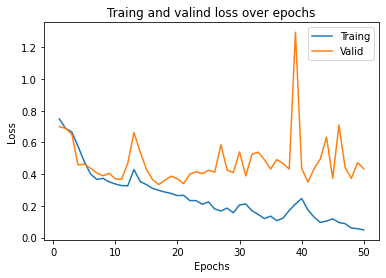

In [43]:
# LR = 1e-3
import matplotlib.pyplot as plt
  
plt.plot(range(1, EPOCHS+1), Train_loss, label = "Traing")
plt.plot(range(1, EPOCHS+1), Val_loss, label = "Valid")
plt.title('Traing and valind loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [45]:
predict_real = 0
predict_fake = 0
tp = 0
fp = 0
tn = 0
fn = 0
epoch_loss = 0
epoch_acc = 0
model.load_state_dict(torch.load('vgg16-3layers-1st-1e-3.pt'))
            
with torch.no_grad():
    for (x, y) in tqdm(test_iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            top_pred = y_pred.argmax(1, keepdim=True)
            correct = top_pred.eq(y.view_as(top_pred)).sum()
            acc = correct.float() / y.shape[0]
            for index in range(len(y)):
                label = y[index]
                predict = top_pred[index]
                if int(predict) == 1:
                    predict_real += 1
                    if int(label) == 1:
                        tn += 1
                    if int(label) == 0:
                        fn += 1
                if int(predict) == 0:
                    predict_fake += 1
                    if int(label) == 0:
                        tp += 1
                    if int(label) == 1:
                        fp += 1

            epoch_loss += loss.item()
            epoch_acc += acc.item()


precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print("Lowest loss happens in epoch " + str(best_epoch + 1))
print(f'Total Time Spent: {epoch_mins}m {epoch_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

print('The number of predicted real images: {}'.format(predict_real))
print('The number of predicted fake images: {}'.format(predict_fake))
print('The number of correctly predicted real images: {}'.format(tn))
print('The number of correctly predicted fake images: {}'.format(tp))
print('The number of predicted fake images that should be real: {}'.format(fp))
print('The number of predicted real images that should be fake: {}'.format(fn))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1 score: {}'.format(f1))
print('test loss: {}'.format(test_loss))
print('test accuracy: {}'.format(test_acc))


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Lowest loss happens in epoch 17
Total Time Spent: 1.0m 33s
Test Loss: 0.315 | Test Acc: 87.70%
The number of predicted real images: 178
The number of predicted fake images: 206
The number of correctly predicted real images: 173
The number of correctly predicted fake images: 162
The number of predicted fake images that should be real: 44
The number of predicted real images that should be fake: 5
precision: 0.7864077669902912
recall: 0.9700598802395209
f1 score: 0.868632707774799
test loss: 0.3148318976163864
test accuracy: 0.876953125
